# Robust Clustering on High-Dimensional Data with Stochastic Quantization

[![Arxiv](https://img.shields.io/badge/arXiv-2409.02066-B21A1B)](https://doi.org/10.48550/arXiv.2409.02066)
[![Open In GitHub](https://img.shields.io/badge/GitHub-100000?logo=github&logoColor=white)](https://github.com/kaydotdev/stochastic-quantization)

The Stochastic Quantization algorithm reframes the clustering problem as a stochastic transportation problem by minimizing the distance between elements of the original distribution $\{\xi\}$ and atoms of the encoded discrete distribution $\{y_k\}$. This approach employs Stochastic Gradient Descent (SGD), as well as its accelerated modifications (Momentum, Nesterov Accelerated Gradient) and adaptive learning rate modifications (AdaGrad, RMSProp, ADAM), to search for an optimal minimum, leveraging its computational efficiency in large-scale machine learning problems. The use of stochastic approximation allows the algorithm to update parameters with only one element $\xi$ per iteration, ensuring memory efficiency without compromising convergence to the minimum. We employed a Triplet Loss Siamese Network (a Triplet Network) as a semi-supervised algorithm for dimensionality reduction.

To illustrate the efficiency and scalability of the Stochastic Quantization algorithm, we conducted experiments on a semi-supervised image classification problem using partially labeled data. A Triplet Network was initially trained on the labeled portion of the dataset as a supervised learning model. For implementation and training of the Triplet Network, we utilized [PyTorch 2.0](https://doi.org/10.1145/3620665.3640366), a framework designed for high-performance parallel computations on accelerated hardware. The Stochastic Quantization algorithm was implemented using the high-level API of [Scikit-learn](https://scikit-learn.org/), ensuring compatibility with other package components (e.g., model training and evaluation), while leveraging [NumPy](https://doi.org/10.1038/s41586-020-2649-2) for efficient tensor computations on CPU. All figures presented in this study were generated using [Matplotlib](https://doi.org/10.1109/MCSE.2007.55).

In [1]:
import os
import itertools

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib as mpl
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

from sklearn.metrics import ConfusionMatrixDisplay, f1_score

import sq

In order to ensure reproducibility of our results, we have initialized the random seed to 42 for both the Numpy and PyTorch backends. In case of a `CUDA`-enabled device utilization for PyTorch operations, we configured the cuDNN backend to employ `deterministic` algorithms for convolution operations consistently across multiple runs (for further details, refer to the PyTorch documentation on [torch.backends.cudnn.deterministic](https://pytorch.org/docs/stable/backends.html#torch.backends.cudnn.deterministic)).

In [2]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

print(f"Used random seed: {torch.initial_seed()}")

Used random seed: 42


The use of a `CUDA`-enabled device is highly recommended for this experiment to ensure efficient parallel computations. However, the available computation device will be automatically detected for the PyTorch backend.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Used device: {device}")

Used device: cuda


For our experiments, we utilized the original [MNIST handwritten digit dataset](https://yann.lecun.com/exdb/mnist/). This dataset comprises 60,000 grayscale images of handwritten digits, each with a resolution of 28x28 pixels. Each image is associated with a class label ranging from 0 to 9. Additionally, the dataset includes a corresponding set of 10,000 test images with their respective labels. It is important to note that we did not apply any data augmentation or preprocessing techniques to either the training or test datasets. We approached the image classification task as a semi-supervised learning problem. Our models were trained on varying fractions of labeled training data. The ratio of labeled training data can be adjusted using the `TRAIN_SUBSET_SIZE` variable.

In [4]:
EPOCHS = 50

BATCH_TRAIN = 1000  # The batch size is calculated as (1000 * ratio)
BATCH_TEST = 10000
DATA_DIR = "../../data/"
RESULTS_DIR = "../../results/"

TRAIN_SUBSET_SIZE = 1.

train_dataset = datasets.MNIST(
    root=DATA_DIR, train=True, download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

train_subset_size = int(len(train_dataset) * TRAIN_SUBSET_SIZE)
train_subset_ids = np.random.RandomState(RANDOM_SEED).randint(0, len(train_dataset), size=train_subset_size)
train_subset = torch.utils.data.Subset(train_dataset, train_subset_ids)

test_dataset = datasets.MNIST(
    root=DATA_DIR, train=False, download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

train_dataloader = DataLoader(train_subset, batch_size=BATCH_TRAIN, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_TEST, shuffle=True)

The figure below represents samples from the dataset with their corresponding labels.

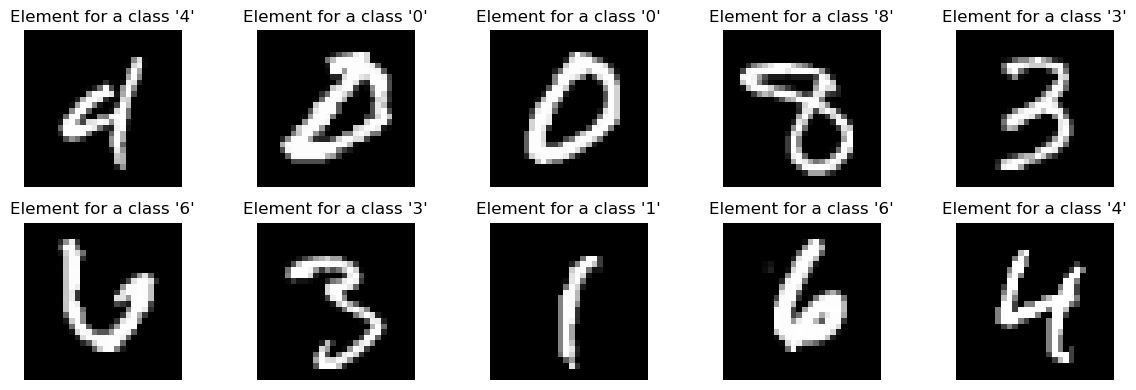

In [5]:
# Selecting random samples for the visual showcase
row_elements = 5

fig, axes = plt.subplots(2, row_elements, figsize=(12, 4), tight_layout=True)

# Display the samples in the image grid
for i, (image, label) in enumerate(
  itertools.islice(train_subset, 2 * row_elements)
):
    row = i // row_elements
    col = i % row_elements

    axes[row, col].imshow(image.squeeze(), cmap="gray")
    axes[row, col].set_title(f"Element for a class '{label}'")
    axes[row, col].axis("off")

# Show the plot
plt.show()

The phenomenon of clustering high-dimensional data is susceptible to the "curse of dimensionality," where the distinction between the nearest and farthest points becomes increasingly negligible:

$$ \lim_{n \to \infty} \frac{\max d(\xi_i, y_k) - \min d(\xi_i, y_k)}{\min d(\xi_i, y_k)} = 0 $$

To address this issue, we have employed the Triplet Network for dimensionality reduction, as introduced by Hoffer et al. This approach is a modification of the Contrastive Learning framework. The core idea of the Triplet Network is to train the model using triplets of samples:

1. An anchor sample $\xi_i$: a randomly sampled element from the feature set $\Xi$.
2. A positive sample $\xi^{+}_i$: an element with a label similar to the anchor $\xi_i$.
3. A negative sample $\xi^{-}_i$: an element with a label different from the anchor $\xi_i$.

Unlike traditional Contrastive Learning, which compares only positive $\xi^{+}_i$ and negative $\xi^{-}_i$ samples, the Triplet Network learns to minimize the distance between the anchor and positive samples while maximizing the distance between the anchor and negative samples. This approach is achieved using the triplet loss objective function:

$$ \mathcal{L}_{triplet}(\theta) = \max (0, d(f_{\theta}(\xi_i), f_{\theta}(\xi^{+}_i)) - d(f_{\theta}(\xi_i), f_{\theta}(\xi^{-}_i)) + \alpha) $$

where $f_{\theta}: \Xi \to \mathbb{R}^n$ is a parameterized abstract operator mapping discrete elements $\Xi$ into latent representations (in our case, a Triplet Network with weights $\theta$), $d: [\mathbb{R}^n, \mathbb{R}^n] \to \mathbb{R}$ is a distance metric between samples, $\alpha$ is a margin hyperparameter enforcing a minimum separation between positive and negative pairs. This approach allows for more effective clustering of high-dimensional data by learning meaningful representations that preserve important relationships between samples.

In [6]:
class TripletNetwork(nn.Module):    
    def __init__(self, latent_dim=3):
        super(TripletNetwork, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Flatten(),

            nn.Linear(64 * 7 * 7, 64),
            nn.ReLU(),

            nn.Linear(64, latent_dim),
        )

    def forward(self, x):
        return self.encoder(x)

The selection of an appropriate triplet mining strategy for $(\xi_i, \xi^+_i, \xi^-_i)$ is crucial in generating the most informative gradients for the objective function $\mathcal{L}_{triplet}$. In our approach, we implemented an online triplet mining strategy that dynamically selects triplets within each batch of the training set during each iteration. Specifically, we employed the semi-hard triplet mining strategy, which identifies an anchor-negative pair that exceeds the distance of the anchor-positive pair while remaining within the margin $\alpha$. This strategy can be formally expressed as:

$$\xi^-_i = \underset{\substack{\xi: C(\xi) \neq C(\xi_i) \\ d(f_{\theta}(\xi_i), f_{\theta}(\xi)) > d(f_{\theta}(\xi_i), f_{\theta}(\xi^+_i))}}{\operatorname{\arg \min}} d(f_{\theta}(\xi_i), f_{\theta}(\xi))$$

where $C(\xi)$ denotes the class label of an element $\xi$.

In [7]:
def get_semihard_triplets(embeddings, labels, margin=1.0):
    pairwise_dist = torch.cdist(embeddings, embeddings)

    # Create a mask for positive pairs (same label)
    labels_equal = labels.unsqueeze(0) == labels.unsqueeze(1)
    positive_mask = labels_equal.to(embeddings.device)

    # Create a mask for negative pairs (different label)
    negative_mask = ~positive_mask

    # Exclude self-comparisons
    mask_no_self = ~torch.eye(embeddings.shape[0], dtype=torch.bool, device=embeddings.device)
    positive_mask = positive_mask & mask_no_self
    negative_mask = negative_mask & mask_no_self

    # Find the hardest positive for each anchor
    hardest_positive_dist, _ = (pairwise_dist * positive_mask.float()).max(dim=1)

    # Find semi-hard negatives for each anchor
    semi_hard_negative_mask = (pairwise_dist > hardest_positive_dist.unsqueeze(1)) & \
                              (pairwise_dist < hardest_positive_dist.unsqueeze(1) + margin) & \
                              negative_mask

    # If no semi-hard negative exists, use the hardest negative
    for i in range(embeddings.shape[0]):
        if not semi_hard_negative_mask[i].any():
            _, hard_negative_idx = (pairwise_dist[i] * negative_mask[i].float()).min(dim=0)
            semi_hard_negative_mask[i, hard_negative_idx] = True

    # Sample triplets
    anchors = []
    positives = []
    negatives = []

    for i in range(embeddings.shape[0]):
        positive_indices = torch.where(positive_mask[i])[0]
        negative_indices = torch.where(semi_hard_negative_mask[i])[0]

        if len(positive_indices) > 0 and len(negative_indices) > 0:
            positive_idx = positive_indices[torch.randint(0, len(positive_indices), (1,))]
            negative_idx = negative_indices[torch.randint(0, len(negative_indices), (1,))]

            anchors.append(embeddings[i])
            positives.append(embeddings[positive_idx].squeeze(0))
            negatives.append(embeddings[negative_idx].squeeze(0))

    return torch.stack(anchors), torch.stack(positives), torch.stack(negatives)

For the Triplet Network, we employed a Convolutional Neural Network architecture consisting of two Convolutional Layers with 3x3 filters (feature map dimensions of 32 and 64, respectively, with $\text{stride}=1$ and $\text{padding}=1$), followed by 2x2 Max-Pooling layers, and two Dense Layers. ReLU non-differentiable activation functions were utilized throughout the network, introducing non-linearity to each layer. Together with non-smooth Triplet loss function this makes the learning problem highly non-smooth and non-convex. We trained separate Triplet Network models for each labeled data fraction with the following hyperparameters: 50 epochs, batch size of $1000 \times \text{fraction}$, learning rate $\rho = 10^{-3}$, and $l_2$ regularization rate $\lambda = 10^{-5}$. For the triplet loss and triplet mining, we set the margin hyperparameter $\alpha = 1.0$.

In [8]:
LATENT_DIM = 3
TRIPLET_MARGIN = 1.0

triplet_network = TripletNetwork(latent_dim=LATENT_DIM).to(device)
criterion = nn.TripletMarginLoss(margin=TRIPLET_MARGIN, p=2)
optimizer = optim.Adam(triplet_network.parameters(), lr=1e-3, weight_decay=1e-05)

train_loss, val_loss = [], []


for epoch in range(EPOCHS):
    epoch_train_loss = []
    epoch_val_loss = []

    # Training loss and accuracy
    triplet_network.train()

    for images, labels in (progress_bar := tqdm(train_dataloader)):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()

        output = triplet_network(images)
        loss = criterion(*get_semihard_triplets(output, labels, margin=TRIPLET_MARGIN))

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        epoch_train_loss.append(loss.item())
        progress_bar.set_description(f"Train loss: {loss.item():.4f}")

    train_loss.append(np.mean(np.array(epoch_train_loss)))

    # Validation loss and accuracy
    triplet_network.eval()

    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            output = triplet_network(images)
            loss = criterion(*get_semihard_triplets(output, labels))

            epoch_val_loss.append(loss.item())

    val_loss.append(np.mean(np.array(epoch_val_loss)))

    print(f"Validation loss: {loss.item():.4f}")

Train loss: 0.0162: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.07it/s]


Validation loss: 0.0451


Train loss: 0.0179: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:27<00:00,  2.17it/s]


Validation loss: 0.0120


Train loss: 0.0056: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.13it/s]


Validation loss: 0.0021


Train loss: 0.0055: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.12it/s]


Validation loss: 0.0011


Train loss: 0.0061: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.12it/s]


Validation loss: 0.0015


Train loss: 0.0024: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:27<00:00,  2.16it/s]


Validation loss: 0.0010


Train loss: 0.0049: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:27<00:00,  2.14it/s]


Validation loss: 0.0010


Train loss: 0.0056: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:27<00:00,  2.16it/s]


Validation loss: 0.0012


Train loss: 0.0080: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:27<00:00,  2.16it/s]


Validation loss: 0.0006


Train loss: 0.0240: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.14it/s]


Validation loss: 0.0016


Train loss: 0.0153: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.12it/s]


Validation loss: 0.0008


Train loss: 0.1206: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.12it/s]


Validation loss: 0.0006


Train loss: 0.0161: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.14it/s]


Validation loss: 0.0009


Train loss: 0.0184: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.14it/s]


Validation loss: 0.0010


Train loss: 0.0156: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.11it/s]


Validation loss: 0.0008


Train loss: 0.0043: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:27<00:00,  2.14it/s]


Validation loss: 0.0005


Train loss: 0.0089: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.11it/s]


Validation loss: 0.0009


Train loss: 0.0474: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.14it/s]


Validation loss: 0.0004


Train loss: 0.0244: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.13it/s]


Validation loss: 0.0007


Train loss: 0.0065: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.14it/s]


Validation loss: 0.0006


Train loss: 0.0075: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:27<00:00,  2.15it/s]


Validation loss: 0.0008


Train loss: 0.0140: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:27<00:00,  2.16it/s]


Validation loss: 0.0006


Train loss: 0.0205: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.13it/s]


Validation loss: 0.0005


Train loss: 0.0372: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.13it/s]


Validation loss: 0.0006


Train loss: 0.0754: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.14it/s]


Validation loss: 0.0008


Train loss: 0.0068: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.10it/s]


Validation loss: 0.0005


Train loss: 0.0576: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.11it/s]


Validation loss: 0.0006


Train loss: 0.1183: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:27<00:00,  2.17it/s]


Validation loss: 0.0006


Train loss: 0.0057: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.09it/s]


Validation loss: 0.0007


Train loss: 0.0197: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.10it/s]


Validation loss: 0.0009


Train loss: 0.0698: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:27<00:00,  2.17it/s]


Validation loss: 0.0009


Train loss: 0.0545: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:27<00:00,  2.16it/s]


Validation loss: 0.0007


Train loss: 0.0116: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:27<00:00,  2.15it/s]


Validation loss: 0.0010


Train loss: 0.0161: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:27<00:00,  2.15it/s]


Validation loss: 0.0002


Train loss: 0.0549: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.09it/s]


Validation loss: 0.0007


Train loss: 0.2675: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.12it/s]


Validation loss: 0.0010


Train loss: 0.0161: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.12it/s]


Validation loss: 0.0010


Train loss: 0.0060: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:27<00:00,  2.17it/s]


Validation loss: 0.0007


Train loss: 0.0524: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.11it/s]


Validation loss: 0.0006


Train loss: 0.0347: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.13it/s]


Validation loss: 0.0008


Train loss: 0.0147: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.13it/s]


Validation loss: 0.0007


Train loss: 0.0211: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.14it/s]


Validation loss: 0.0005


Train loss: 0.1525: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.08it/s]


Validation loss: 0.0010


Train loss: 0.0072: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.09it/s]


Validation loss: 0.0009


Train loss: 0.1162: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.11it/s]


Validation loss: 0.0007


Train loss: 0.0381: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.10it/s]


Validation loss: 0.0006


Train loss: 0.0894: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.11it/s]


Validation loss: 0.0008


Train loss: 0.1113: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:27<00:00,  2.14it/s]


Validation loss: 0.0005


Train loss: 0.1315: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.10it/s]


Validation loss: 0.0004


Train loss: 0.0530: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.13it/s]


Validation loss: 0.0011


By applying concepts from previously mentioned research, we can utilize the encoded latent representations of the Triplet Network to train a Stochastic Quantization algorithm. This novel approach enables us to solve supervised or semi-supervised classification problems on high-dimensional data. The semi-supervised learning process using the combined algorithm, assuming we have a labeled subset $\Xi^\prime \subset \Xi$ and remaining unlabeled data $\bar{\Xi}=\Xi\setminus \Xi^\prime$, can be summarized as follows:

1. Train a Triplet Network $f_{\theta}$ on labeled data $\Xi^\prime$ and generate their encoded latent representations in $\mathbb{R}^n$.
2. Use the trained Triplet Network $f_{\theta}$ to project the remaining unlabeled data $\bar{\Xi}$ onto the same latent representation space $\mathbb{R}^n$.
3. Employ both labeled and unlabeled latent representations to train a Stochastic Quantization algorithm.

In [9]:
def group_embeddings_by_label(model: nn.Module, dataloader: DataLoader):
    all_embeddings = np.empty((0, LATENT_DIM))
    grouped_embeddings = {i: np.empty((0, LATENT_DIM)) for i in range(10)}

    for img, lbs in dataloader:
        model_device = next(model.parameters()).device
        batch_embeddings = model(img.to(model_device))
        batch_embeddings = batch_embeddings.cpu().detach().numpy()

        lbs = lbs.detach().numpy()

        for emb, lb in zip(batch_embeddings, lbs):
            grouped_embeddings[lb] = np.vstack((grouped_embeddings[lb], np.array(emb)))

    for cl, embeds in grouped_embeddings.items():
        all_embeddings = np.vstack((all_embeddings, np.array(embeds)))

    return grouped_embeddings, all_embeddings


embedding_model = triplet_network.encoder

with torch.no_grad():
    train_group_embeds, train_all_embeds = group_embeddings_by_label(embedding_model, train_dataloader)
    test_group_embeds, test_all_embeds = group_embeddings_by_label(embedding_model, test_dataloader)

To facilitate meaningful feature capture while enabling visualization, we chose a latent space $\mathbb{R}^3$. The figure below displays latent representations of images from both the training dataset (left) and test dataset (right) projected by the Triplet Network. Each point is color-coded according to its corresponding digit label (0-9). The evident clustering of points with the same label suggests that the Triplet Network successfully captured relevant features during the training process.

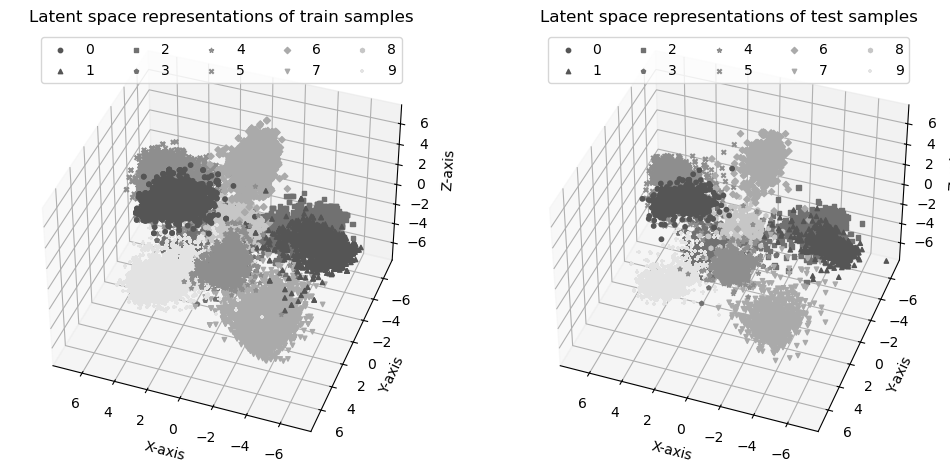

In [10]:
markers = ["o", "^", "s", "p", "*", "x", "D", "v", "h", "+"]
markers_color = mpl.colormaps["gray"].resampled(len(markers))
markers_color_range = np.linspace(0.3, 0.8, len(markers))

marksize = 10
elev, azim = 40, 110

fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(1, 2, 1, projection="3d")
ax.view_init(elev=elev, azim=azim, roll=0)

for idx, (cls, embeds) in enumerate(train_group_embeds.items()):
    cls_color = markers_color(markers_color_range[idx])

    ax.scatter(embeds[:, 0], embeds[:, 1], embeds[:, 2], color=cls_color, label=cls,
               alpha=1.0, s=marksize, marker=markers[idx % len(markers)])

ax.legend(loc="upper center", ncol=5)
ax.set_title("Latent space representations of train samples")

ax.set_xlabel("X-axis")
ax.set_xlim((-7.5, 7.5))

ax.set_ylabel("Y-axis")
ax.set_ylim((-7.5, 7.5))

ax.set_zlabel("Z-axis")
ax.set_zlim((-7.5, 7.5))

ax = fig.add_subplot(1, 2, 2, projection="3d")
ax.view_init(elev=elev, azim=azim, roll=0)

for idx, (cls, embeds) in enumerate(test_group_embeds.items()):
    cls_color = markers_color(markers_color_range[idx])

    ax.scatter(embeds[:, 0], embeds[:, 1], embeds[:, 2], color=cls_color, label=cls,
               alpha=1.0, s=marksize, marker=markers[idx % len(markers)])

ax.legend(loc="upper center", ncol=5)
ax.set_title("Latent space representations of test samples")

ax.set_xlabel("X-axis")
ax.set_xlim((-7.5, 7.5))

ax.set_ylabel("Y-axis")
ax.set_ylim((-7.5, 7.5))

ax.set_zlabel("Z-axis")
ax.set_zlim((-7.5, 7.5))

fig.patch.set_facecolor("white")

plt.show()

Optimal quantization minimizes the weighted sum of distances between elements of the feature set $\{\xi_i\} \subset \mathbb{R}^{n}$ and centers $\{y_k\} \subset \mathbb{R}^{n}$:

$$ \min_{y = \{ y_1, \ldots, y_K \} \in Y^K \subset \mathbb{R}^{nK}} \min_{q = \{ q_1, \ldots, q_K \} \in \mathbb{R}^K_{+}} \min_{x = \{ x_{ik} \geq 0 \}} \sum_{i=1}^I \sum_{k=1}^K d(\xi_i, y_k)^r x_{ik} $$
$$ \sum_{k=1}^K x_{ik} = p_i, \quad \sum_{k=1}^K q_k = 1, \quad i = 1, \ldots, I $$

where $p_i > 0, \sum_{i=1}^I p_i = 1$ are normalized supply volumes, $x_{ik}$ are transportation volumes, $d(\xi_i, y_k)_p = \| \xi_i - y_k \|_p = (\sum_{j=1}^n | \xi_{ij} - y_{kj} |^p)^{\frac{1}{p}}$ is the $l_p$ norm defining the distance between elements in the objective function, $Y \subset \mathbb{R}^{n}$ is a common constraint set for variables $\{y_k, k = 1, \ldots, K\}$, $n, I, K \in \mathbb{N}$. In this study, we employ the Euclidean norm ($p = 2$) as the distance metric, defined as $d(\xi_i, y_k)_2 = \sqrt{\sum_{j=1}^n | \xi_{ij} - y_{kj} |^2}$. Given that in the optimal plan, all mass at point $\xi_i$ is transported to the nearest point $y_k$, the problem can be reduced to the following non-convex, non-smooth global stochastic optimization problem:

$$ \min_{y = \{ y_1, \ldots, y_K \} \in Y^K \subset \mathbb{R}^{nK}} F(y_1, \ldots, y_K) $$
$$ F(y) = F(y_1, \ldots, y_K) = \sum_{i=1}^I p_i \min_{1 \leq k \leq K} d(\xi_i, y_k)^r = \mathbb{E}_{i \sim p} \min_{1 \leq k \leq K} d(\xi_i, y_k)^r $$

Here, $\mathbb{E}_{i \sim p}$ denotes the expected value over the random index $i$ that takes values $\{1, \ldots, I\}$ with probabilities $\{p_1, \ldots, p_I\}$, respectively. The empirical approximation of $F(y)$ is:

$$ F_N(y) = \frac{1}{N} \sum_{i=1}^N \min_{1 \leq k \leq K} d(\xi_i, y_k)^r $$

where $\{\tilde{\xi}_j,\; j = 1, \ldots, N\}$ are independent, identically distributed initial samples of the random variable $\xi$. If $K = 1$, $Y$ is convex, and $r\geq 1$, then the problem is unimodal and reduces to a convex stochastic optimization problem:

$$ \min_{y \in Y} [ F(y) =  \mathbb{E}_{\tilde{i} \sim p} d(\xi_{\tilde{i}}, y)^r ] $$

However, for $K \geq 2$, the function $f(\xi, y) = \min_{1 \leq k \leq K} d(\xi, y_k)^r, y = (y_1, \ldots, y_K)$ is the minimum of convex functions and thus is non-smooth and non-convex. The function $f(\xi, y)$ is a random generalized differentiable function of $y$, and its generalized gradient set $\partial_y \,f\,(\xi,y)$ can be calculated by the chain rule:

$$ \partial_y \,f\,(\xi, y) = \text{conv.hull} \left\{ \left(\underbrace{\overbrace{0, \ldots, 0, g_{k}}^k(\xi), 0, \ldots, 0}_K\right), \;\; k \in S(\xi, y), \;\; 0 \in \mathbb{R}^n \right\} $$
$$ S(\xi, y) = \{ k: \| \xi - y_{k} \| = \min_{1 \leq k^{\prime} \leq K} \| \xi - y_{k^{\prime}} \| \} $$
$$ g_{k}(\xi) = r \| \xi - y_{k} \|^{r - 2} (y_{k} - \xi) $$

The expected value function is also generalized differentiable, and the set-valued mathematical expectation $\mathbb{E}_{\xi} \partial_y\, f\,(\xi, y)$ is a generalized gradient set of function $F$. Vectors $G(\xi) = (0, \ldots, 0, g_k, 0, \ldots, 0), \;k \in S(\xi, y), \;0 \in \mathbb{R}^n,$ are stochastic generalized gradients of the function $F(y_1, \ldots, y_K)$. These gradients can be utilized to find the optimal solution $y^{*}=(y_1^{*},\ldots,y_K^{*})$ using Stochastic Gradient Descent (SGD):

$$ y^{t+1}_k = \Pi_{Y} (y^t_k - \rho_t g_k(\tilde{\xi}^t)), \quad \Pi_{Y} (\cdot) = \arg \min_{y \in Y} \| \cdot - y\| $$
$$ y^0_k \in Y, \quad k=1,\ldots,K;\quad t=0,1,\ldots, $$

where $t$ is the iteration number, $\rho_t > 0$ is a learning rate (step) parameter, and $\Pi_{Y}$ is the projection operator onto the set $Y$. $\{\tilde{\xi}^t\}$ are independent identically distributed elements of $\Xi$. In the experiment, we compare the convergence speed of the optimal solution $y^{*}$ search algorithms with different SGD modifications. Momentum Gradient Descent introduces an acceleration multiplier $0 < \gamma < 1$ in the search algorithm:

$$ y^{\,t+1} = y^{\,t} + \gamma (y^{\,t} - y^{\,t-1}) - \rho_t \,g^{\,t}, \quad g^{\,t}\in \partial_y F(y^{\,t}), \quad t = 1,2,\ldots. $$

Nesterov extended this approach by introducing an extrapolation step for more accurate parameter estimation, known as Nesterov Accelerated Gradient (NAG):

$$ \tilde{y}^{\,t} = y^{\,t} - \rho_t g^{\,t}, \quad g^{\,t} \in \partial_y F(y^{\,t}), $$
$$ y^{\,t+1} = \tilde{y}^{\,t} + \gamma (\tilde{y}^{\,t} - \tilde{y}^{\,t-1}), \quad t=1,2,\ldots. $$

Duchi proposed an adaptive learning rate $\tilde{\rho}_k^{t} = \rho_t / \sqrt{G_k^{\,t} + \varepsilon}$, where the learning rate is normalized over the accumulated gradient to prioritize more significant parameters. This approach, known as AdaGrad, is represented by the update rule:

$$ y^{\,t+1}_k = y^{\,t}_k - \frac{\rho_t}{\sqrt{G_k^{\,t} + \varepsilon}} g^{\,t}_k, \quad k=1,\ldots,K, $$

where $G_k = G_{k-1} + g_{k^*}^2$ is the accumulated sum of squared gradients from previous iterations, and $\varepsilon \ll 10^{-8}$ serves as a smoothing term. Tieleman et al. proposed RMSProp, which normalizes the accumulated gradient using a moving average $G_k = \beta G_{k-1} + (1 - \beta) g_{k^*}^2$. Further advancements were made by Kingma et al., who developed the ADAM algorithm, incorporating adaptive moment estimation. The first and second moments of the gradient are estimated as follows:

$$ m_k^{\,t} = \beta_1 m_k^{\,t-1} + (1 - \beta_1) g_k^{\,t}, $$
$$ v_k^{\,t} = \beta_2 v_k^{\,t-1} + (1 - \beta_2) \|g_k^{\,t}\|^2, $$
$$ y_k^{\,t+1} = y_k^{\,t} - \frac{\rho_t}{\sqrt{v_k^{\,t} + \varepsilon}} m_k^{\,t}, \quad k=1,\ldots,K, $$

where $m_k^{\,t}$ represents the adaptive estimate of the first moment (the expected gradient value), and $v_k^{\,t}$ represents the adaptive estimate of the second moment (the variance). The constants $0 < \beta_1 < 1$ and $0 < \beta_2 < 1$ are used as averaging multipliers.

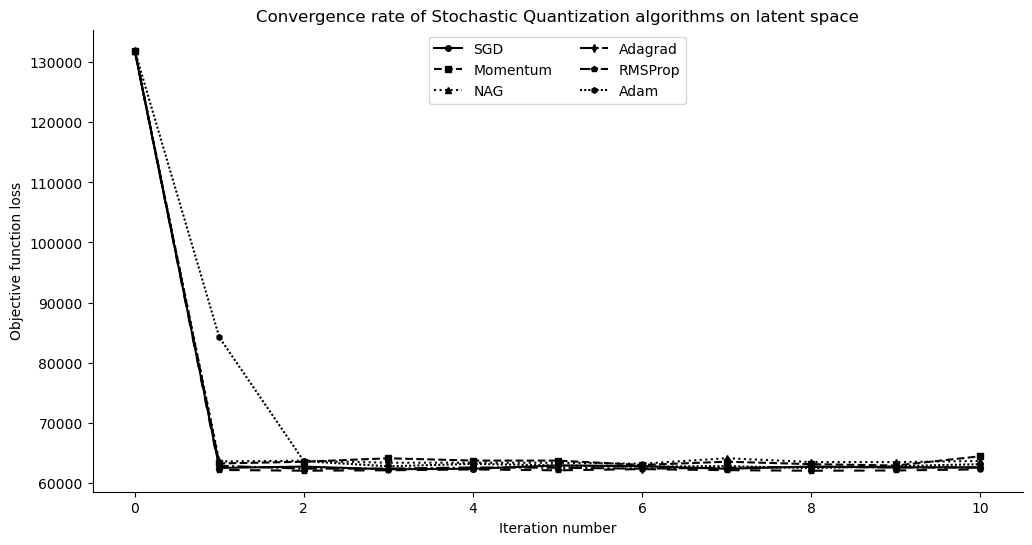

In [11]:
SQ_ITERS = 10

sq_algorithms = {
    "SGD": sq.StochasticQuantization(sq.SGDOptimizer(), n_clusters=10, max_iter=SQ_ITERS,
                                     random_state=np.random.RandomState(RANDOM_SEED)),
    "Momentum": sq.StochasticQuantization(sq.MomentumOptimizer(), n_clusters=10, max_iter=SQ_ITERS,
                                          random_state=np.random.RandomState(RANDOM_SEED)),
    "NAG": sq.StochasticQuantization(sq.NAGOptimizer(), n_clusters=10, max_iter=SQ_ITERS,
                                     random_state=np.random.RandomState(RANDOM_SEED)),
    "Adagrad": sq.StochasticQuantization(sq.AdagradOptimizer(), n_clusters=10, max_iter=SQ_ITERS,
                                         learning_rate=0.9, random_state=np.random.RandomState(RANDOM_SEED)),
    "RMSProp": sq.StochasticQuantization(sq.RMSPropOptimizer(), n_clusters=10, max_iter=SQ_ITERS,
                                         learning_rate=0.01, random_state=np.random.RandomState(RANDOM_SEED)),
    "Adam": sq.StochasticQuantization(sq.AdamOptimizer(), n_clusters=10, max_iter=SQ_ITERS,
                                      learning_rate=0.01, random_state=np.random.RandomState(RANDOM_SEED))
}

markers = [("o", "-"), ("s", "--"), ("^", ":"), ("d", "-."), ("p", (0, (5, 5))), ("h", (0, (1, 1)))]
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for idx, (name, alg) in enumerate(sq_algorithms.items()):
    marker, linestyle = markers[idx % len(markers)]

    alg = alg.fit(train_all_embeds)

    ax.plot(range(len(alg.loss_history_)), alg.loss_history_,
            linestyle=linestyle, marker=marker, color="k",
            markersize=4, label=name)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.title("Convergence rate of Stochastic Quantization algorithms on latent space")
plt.xlabel("Iteration number")
plt.ylabel("Objective function loss")
plt.legend(loc="upper center", ncol=2)
plt.show()

To evaluate the performance of our classification model across different classes, we utilize a confusion matrix. This widely-used evaluation metric provides a comprehensive visualization of the model's accuracy for each class, enabling us to assess both overall performance and class-specific strengths or weaknesses. The confusion matrix is particularly valuable in our context of high-dimensional data classification, as it helps identify potential biases or misclassifications that may arise from the Stochastic Quantization algorithm. By analyzing the diagonal and off-diagonal elements of the matrix, we can quantify true positives, false positives, true negatives, and false negatives for each class, offering insights into the robustness of our approach. The confusion matrix, denoted as $C_{ij}$, where $i$ and $j$ represent the predicted and actual classes respectively, is computed as follows:

$$ C_{ij} = \sum_{k=1}^{n} \mathbb{1}(y_k = i \wedge \hat{y}_k = j) $$

Here, $n$ is the number of samples, $y_k$ is the true label, and $\hat{y}_k$ is the predicted label for the $k$-th sample. The indicator function $\mathbb{1}(\cdot)$ returns 1 if the condition is true and 0 otherwise.

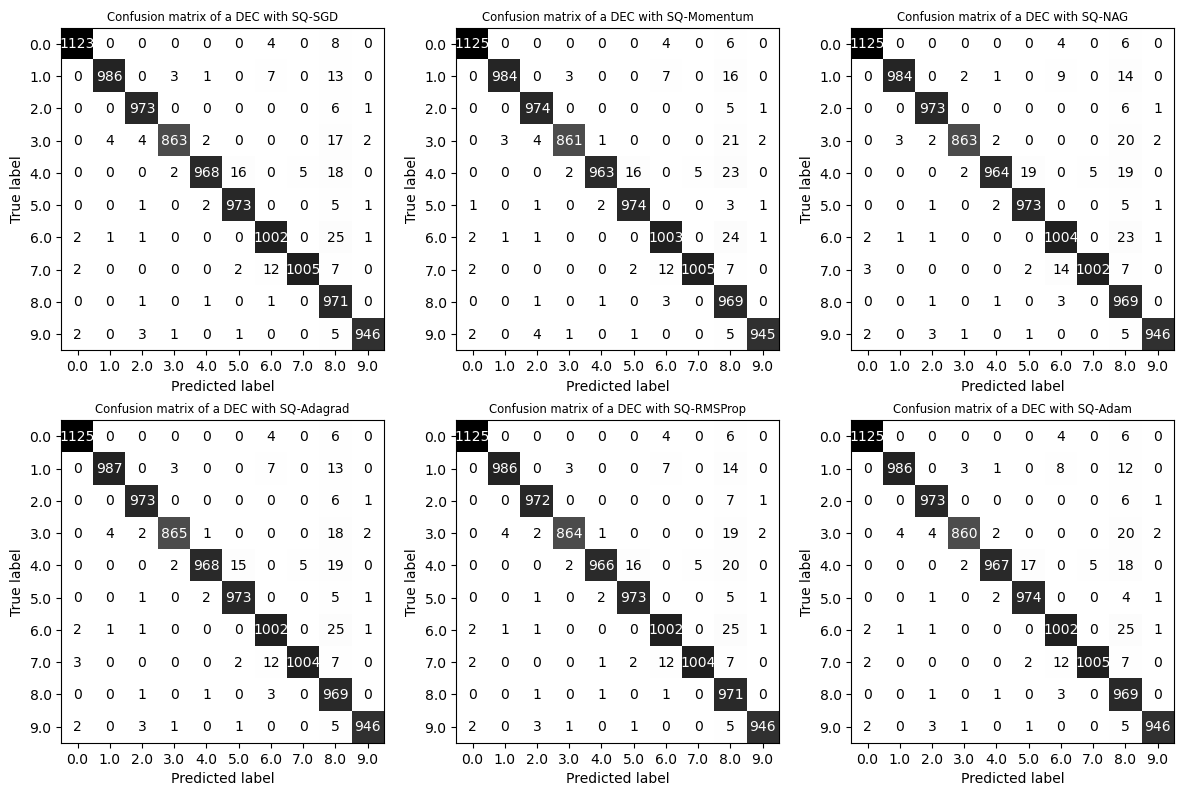

In [12]:
n_col, n_row = (2, 3)
fig, ax = plt.subplots(n_col, n_row, figsize=(12, 8), tight_layout=True)
f1_scores = {}

for idx, (name, alg) in enumerate(sq_algorithms.items()):
    y_true, y_pred = np.array([]), np.array([])

    for _, embs in test_group_embeds.items():
        cls = alg.predict(embs)
        cls_predicted = np.bincount(cls).argmax()

        y_true = np.append(y_true, np.full((1, len(embs)), cls_predicted))
        y_pred = np.append(y_pred, cls)

    ax_idx = ax[idx // n_row, idx % n_row]

    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, cmap="Greys", colorbar=False, ax=ax_idx
    )

    ax_idx.set_title(f"Confusion matrix of a DEC with SQ-{name}", size="small")
    f1_scores[name] = f1_score(y_true, y_pred, average="weighted")

plt.show()

To address a slight label imbalance in the test set, we adopt a weighted F1 score as our primary accuracy metric. The weighted F1 score, $F1_w$, is calculated as:

$$ F1_w = \sum_{i=1}^{m} w_i \cdot \frac{2 \cdot precision_i \cdot recall_i}{precision_i + recall_i} $$

where $m$ is the number of classes, $w_i$ is the weight of the $i$-th class (typically proportional to its frequency), and $precision_i$ and $recall_i$ are the precision and recall for the $i$-th class, respectively. This metric provides a balanced assessment of model performance, accounting for both precision and recall while considering class distribution.

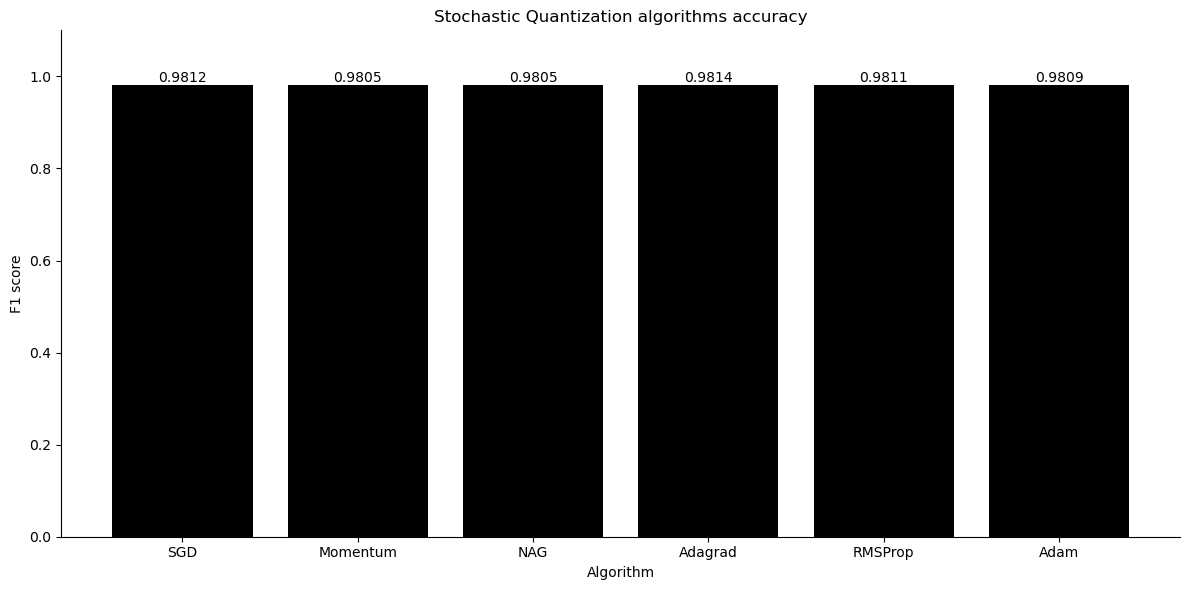

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), tight_layout=True)

bars = ax.bar(f1_scores.keys(), f1_scores.values(), color="k")

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0,
            height, f"{round(height, 4)}", ha="center", va="bottom")

ax.set_xlabel("Algorithm")
ax.set_ylabel("F1 score")
ax.set_title("Stochastic Quantization algorithms accuracy")
ax.set_ylim(top=1.1)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show()

In addition to the quantitative analysis, we visually compare the accuracy of the final convergence by displaying the positions of quants for each algorithm against data points in the latent space $\mathbb{R}^3$. This visualization complements the embeddings representation described earlier. Our results indicate that all algorithms successfully converged to the global optimum, exhibiting similar quant positions. 

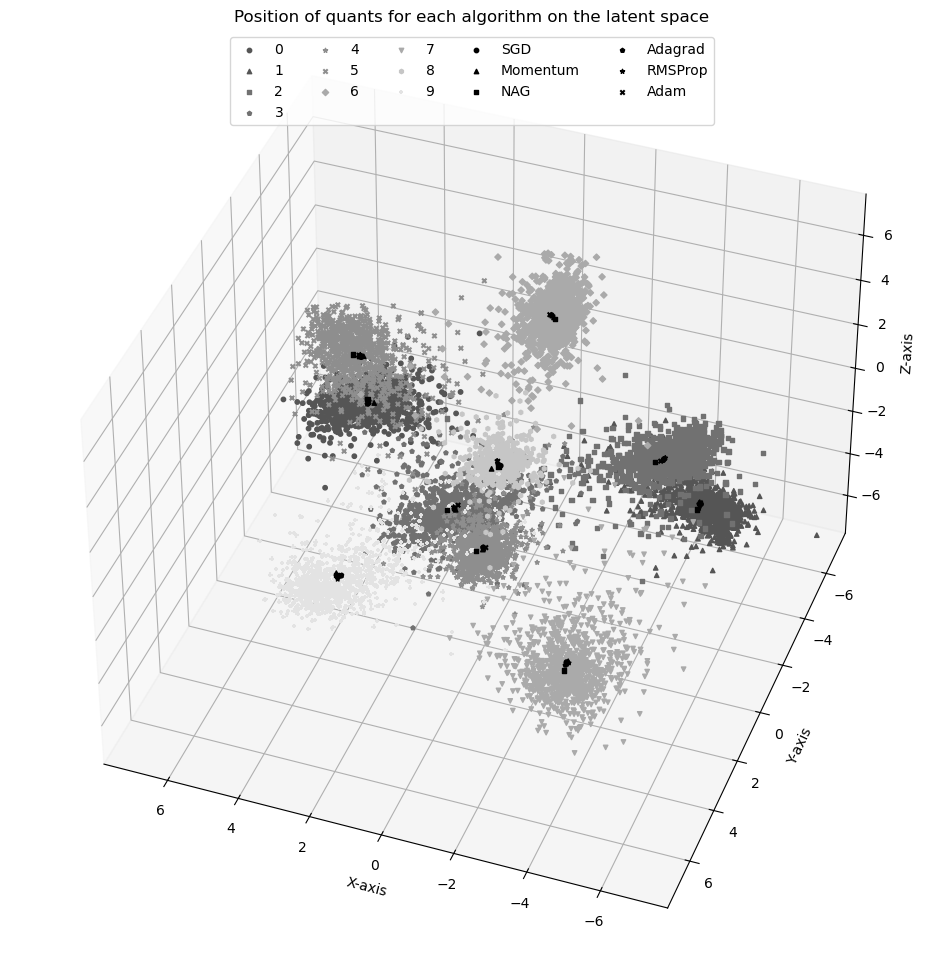

In [14]:
markers = ["o", "^", "s", "p", "*", "x", "D", "v", "h", "+"]
markers_color = mpl.colormaps["gray"].resampled(len(markers))
markers_color_range = np.linspace(0.3, 0.8, len(markers))

marksize = 10

fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(1, 1, 1, projection="3d", computed_zorder=False)
ax.view_init(elev=elev, azim=azim, roll=0)

for idx, (cls, embeds) in enumerate(test_group_embeds.items()):
    cls_color = markers_color(markers_color_range[idx])

    ax.scatter(embeds[:, 0], embeds[:, 1], embeds[:, 2], zorder=1, color=cls_color,
               label=cls, alpha=1.0, s=marksize, marker=markers[idx % len(markers)])

for idx, (name, alg) in enumerate(sq_algorithms.items()):
    ax.scatter(alg.cluster_centers_[:, 0], alg.cluster_centers_[:, 1], alg.cluster_centers_[:, 2],
               zorder=2, color="k", label=name, alpha=1.0, s=marksize, marker=markers[idx % len(markers)])

ax.legend(loc="upper center", ncol=5)
ax.set_title("Position of quants for each algorithm on the latent space")

ax.set_xlabel("X-axis")
ax.set_xlim((-7.5, 7.5))

ax.set_ylabel("Y-axis")
ax.set_ylim((-7.5, 7.5))

ax.set_zlabel("Z-axis")
ax.set_zlim((-7.5, 7.5))

fig.patch.set_facecolor("white")

plt.show()

For subsequent utilization, the encoder model was persisted using the `torch.save()` method provided by PyTorch. This approach facilitates the preservation of the trained model's state and architecture, enabling efficient retrieval and deployment in future applications or analyses.

In [15]:
MODEL_DIR = os.path.join(RESULTS_DIR, "model")

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

embedding_model.eval()

torch.save(embedding_model.state_dict(), os.path.join(MODEL_DIR, "triplet_network.bin"))